<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#map-to-intestine-organoid" data-toc-modified-id="map-to-intestine-organoid-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>map to intestine organoid</a></span><ul class="toc-item"><li><span><a href="#run-model" data-toc-modified-id="run-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>run model</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>plot</a></span></li></ul></li><li><span><a href="#mapping-to-heoa" data-toc-modified-id="mapping-to-heoa-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>mapping to heoa</a></span><ul class="toc-item"><li><span><a href="#load-model" data-toc-modified-id="load-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>load model</a></span></li><li><span><a href="#distance-to-atlas" data-toc-modified-id="distance-to-atlas-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>distance to atlas</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#lr-model" data-toc-modified-id="lr-model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>lr model</a></span></li></ul></li></ul></div>

In [17]:
import pickle
import os
from copy import copy

import numpy as np
import pandas as pd

import scanpy as sc
import anndata
import gseapy

from scarches.models.scpoli import scPoli
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from wilcoxauc import wilcoxauc,top_markers
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from wilcoxauc import wilcoxauc,top_markers


In [2]:
project_dir = "/home/xuq44/projects/hgioa/data/results/organoid_samples_summary"
results_dir = "new_20230705"


## load data

In [3]:
sample_dir='/home/xuq44/projects/hgioa/data/results/samples/Wang_GenomeBio_2022b/'
counts = pd.read_csv(f'{sample_dir}GSE120065_Colon_Cancer_Organoid_TPM.txt.gz', 
                     sep='\t', index_col=0)

counts.columns = [i.replace('-','_') for i in counts.columns]
counts = counts.loc[:,[True if i[2]=='O' else False for i in counts.columns.str.split('_')]]


In [4]:
adata = anndata.AnnData(X = counts.T,
                        obs = pd.DataFrame(counts.columns).set_index(0),
                        var = pd.DataFrame(counts.index).set_index('Gene'))

adata.obs['sample_id'] = ['_'.join(i[:-1]) for i in adata.obs.index.str.split('_')]
adata.obs['condition'] = ['cancer' if i[1]=='C' else 'normal' for i in adata.obs.index.str.split('_')]

adata.obs.head()


,sample_id,condition
0,,
S1_C_O_rep1_1,S1_C_O_rep1,cancer
S1_C_O_rep1_10,S1_C_O_rep1,cancer
S1_C_O_rep1_11,S1_C_O_rep1,cancer
S1_C_O_rep1_12,S1_C_O_rep1,cancer
S1_C_O_rep1_13,S1_C_O_rep1,cancer


In [6]:
plate_level_all = pd.read_csv(f"{project_dir}/results/{results_dir}/gut_scpoli_model/gut_scpoli_color.txt",
                sep='\t', header=None, index_col=0)
plate_level_all = plate_level_all.to_dict()[1]

## mapping to heoa

### load model

In [7]:
def read_sample(adata0):

    malat1 = adata0.var_names.str.startswith('MALAT1')
    mito_genes = adata0.var_names.str.startswith('MT-')
    rb_genes = adata0.var_names.str.startswith(("RPS","RPL"))

    remove = np.add(mito_genes, malat1)
    remove = np.add(remove, rb_genes)
    keep = np.invert(remove)

    adata0 = adata0[:,keep]

    empty_adata = sc.read_h5ad(f"{project_dir}/results/{results_dir}/gut_scpoli_model/empty.h5ad")

    adata0 = anndata.AnnData.concatenate(*[adata0, empty_adata], join='outer', fill_value=0)

    adata0.layers['counts']=adata0.X
    sc.pp.normalize_total(adata0, target_sum=1e4)
    sc.pp.log1p(adata0)
    adata0.raw = adata0

    adata0 = adata0[:,[i for i in empty_adata.var.index if i in adata0.var.index]]


    adata0.obs['level_1']='na'
    adata0.obs['level_2']='na'
    adata0.obs['level_3']='na'

    return adata0

In [8]:
adata0 = read_sample(adata)

In [9]:
ref_path = f'{project_dir}/results/{results_dir}/gut_scpoli_model/scpoli_model/'

scpoli_query = scPoli.load_query_data(
    adata=adata0,
    reference_model=ref_path,
    labeled_indices=[],
)

early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

scpoli_query.train(
    n_epochs=5,
    pretraining_epochs=4,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=100
)

results_dict = scpoli_query.classify(adata0.X, adata0.obs["sample_id"].values)

AnnData object with n_obs × n_vars = 1832 × 2000
    obs: 'sample_id', 'condition', 'batch', 'level_1', 'level_2', 'level_3'
    uns: 'log1p'
    layers: 'counts'
Embedding dictionary:
 	Num conditions: 238
 	Embedding dim: 3
Encoder Architecture:
	Input Layer in, out and cond: 2000 898 3
	Mean/Var Layer in/out: 898 10
Decoder Architecture:
	First Layer in, out and cond:  10 898 3
	Output Layer in/out:  898 2000 

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |████████████████----| 80.0%  - val_loss: 874.6469116211 - val_cvae_loss: 874.6469116211
Initializing unlabeled prototypes with Leiden-Clustering with an unk

In [10]:

adata_latent_source = sc.read_h5ad(f"{project_dir}/results/{results_dir}/gut_scpoli_model/adata_latent_source.h5ad")


In [11]:
#get latent representation of query data
data_latent= scpoli_query.get_latent(
    adata0.X, 
    adata0.obs["sample_id"].values,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata0.obs.copy()

#get label annotations
adata_latent.obs['level_2_pred'] = results_dict['level_2']['preds'].tolist()
adata_latent.obs['level_2_uncert'] = results_dict['level_2']['uncert'].tolist()
adata_latent.obs['classifier_outcome'] = (
    adata_latent.obs['level_2_pred'] == adata_latent.obs['level_2']
)

#get prototypes
labeled_prototypes = scpoli_query.get_prototypes_info()
labeled_prototypes.obs['study'] = 'labeled prototype'
unlabeled_prototypes = scpoli_query.get_prototypes_info(prototype_set='unlabeled')
unlabeled_prototypes.obs['study'] = 'unlabeled prototype'

umap_model = pickle.load(open(f"{project_dir}/results/{results_dir}/gut_scpoli_model/umap_model.sav", 'rb'))
que_embedding = umap_model.transform(adata_latent.X)
adata_latent.obsm['X_umap'] = que_embedding

knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(adata_latent_source.to_df(), adata_latent_source.obs.level_1_late)
adata_latent.obs['predict_level_1_late'] = knn.predict(adata_latent.to_df())

knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(adata_latent_source.to_df(), adata_latent_source.obs.level_2_late)
adata_latent.obs['predict_level_2_late'] = knn.predict(adata_latent.to_df())

knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(adata_latent_source.to_df(), adata_latent_source.obs.tissue)
adata_latent.obs['predict_tissue'] = knn.predict(adata_latent.to_df())

knn_res = pd.DataFrame(knn.predict_proba(adata_latent.to_df()))
knn_res.columns=['knnprob_'+i for i in knn.classes_]
knn_res.index=adata_latent.to_df().index

adata_latent.obs = pd.merge(adata_latent.obs, knn_res, left_index=True, right_index=True)

clf = LogisticRegression().fit(adata_latent_source.to_df(), adata_latent_source.obs.tissue)
clf_res = pd.DataFrame(clf.predict_proba(adata_latent.to_df()))
clf_res.columns=['clfprob_'+i for i in clf.classes_]
clf_res.index=adata_latent.to_df().index
adata_latent.obs = pd.merge(adata_latent.obs, clf_res, left_index=True, right_index=True)

### distance to atlas

In [12]:
knn = NearestNeighbors(n_neighbors=10)
knn.fit(adata_latent_source.to_df())
knn_res = knn.kneighbors(adata_latent.to_df())
mydist = pd.DataFrame(knn_res[0]).mean(1)

In [13]:
adata0.obs['predict_level_2_late'] = adata_latent.obs.predict_level_2_late
adata0.obs['mean_dist'] = mydist.tolist()
adata0.obs['predict_tissue'] = adata_latent.obs.predict_tissue

In [14]:
adata_cancer = adata0[(adata0.obs.condition=='cancer')&
                      (adata0.obs.predict_level_2_late=='colonocytes')]

adata_cancer.obs['isnormal'] = ['abnormal' if i else 'normal' 
        for i in adata_cancer.obs.mean_dist>adata_cancer.obs.mean_dist.median()]

adata_cancer.obs.isnormal.value_counts()

abnormal    271
normal      271
Name: isnormal, dtype: int64

<Axes: xlabel='mean_dist', ylabel='condition'>

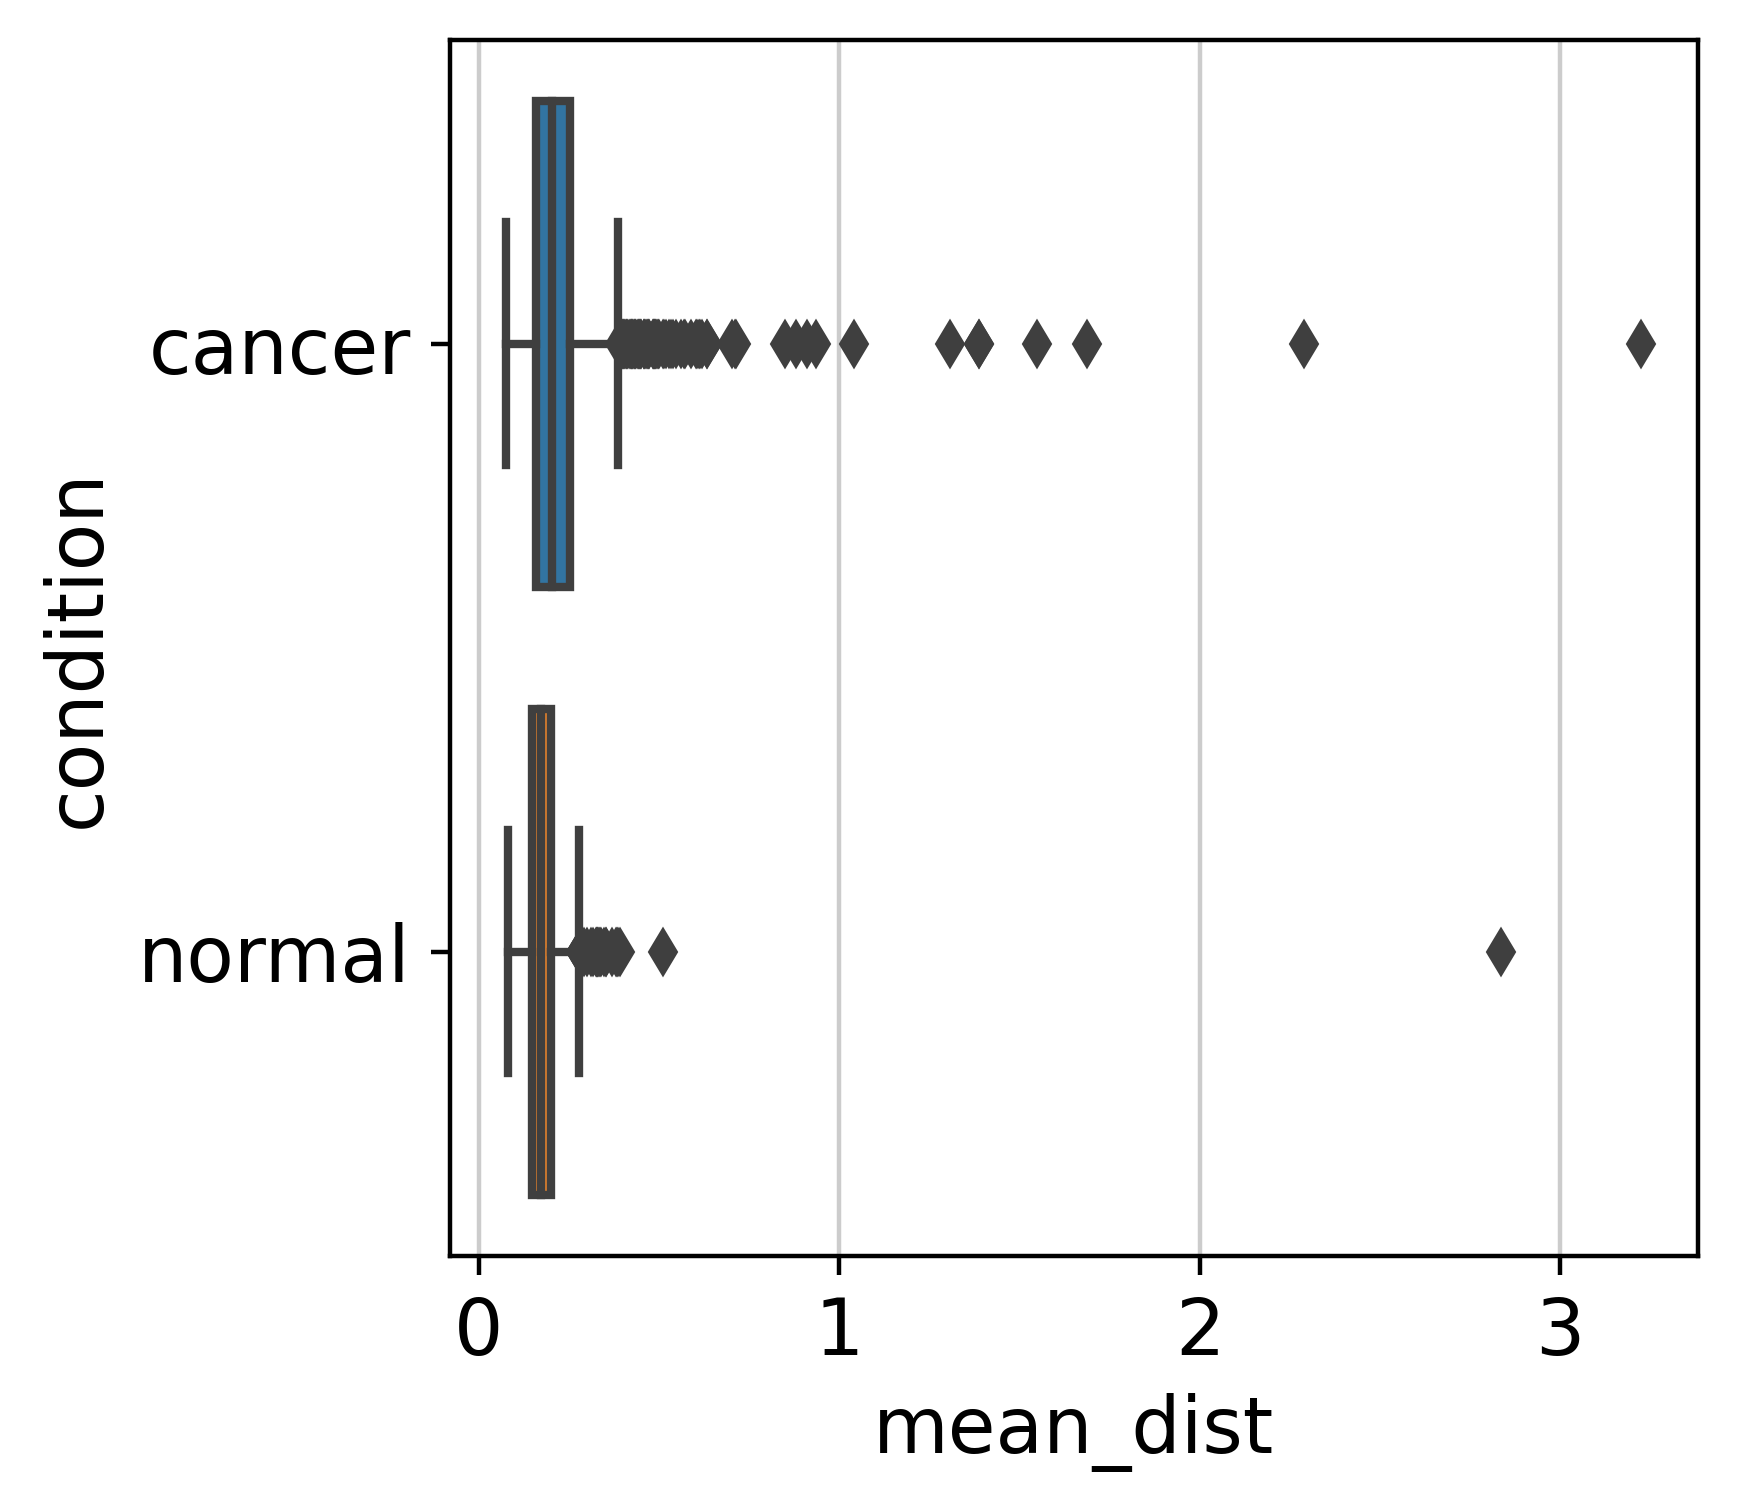

In [15]:
sns.boxplot(data=adata0.obs[['mean_dist','condition']], 
            y='condition', x='mean_dist')

In [18]:
predict_dist = adata0.obs.mean_dist.values
random_dist = adata0.obs.mean_dist.sample(frac=1).values

precision, recall, thresholds = precision_recall_curve([1 if i=='cancer' else 0 for i in adata0.obs.condition], 
                          predict_dist)
precision2, recall2, thresholds2 = precision_recall_curve([1 if i=='cancer' else 0 for i in adata0.obs.condition], 
                          random_dist)

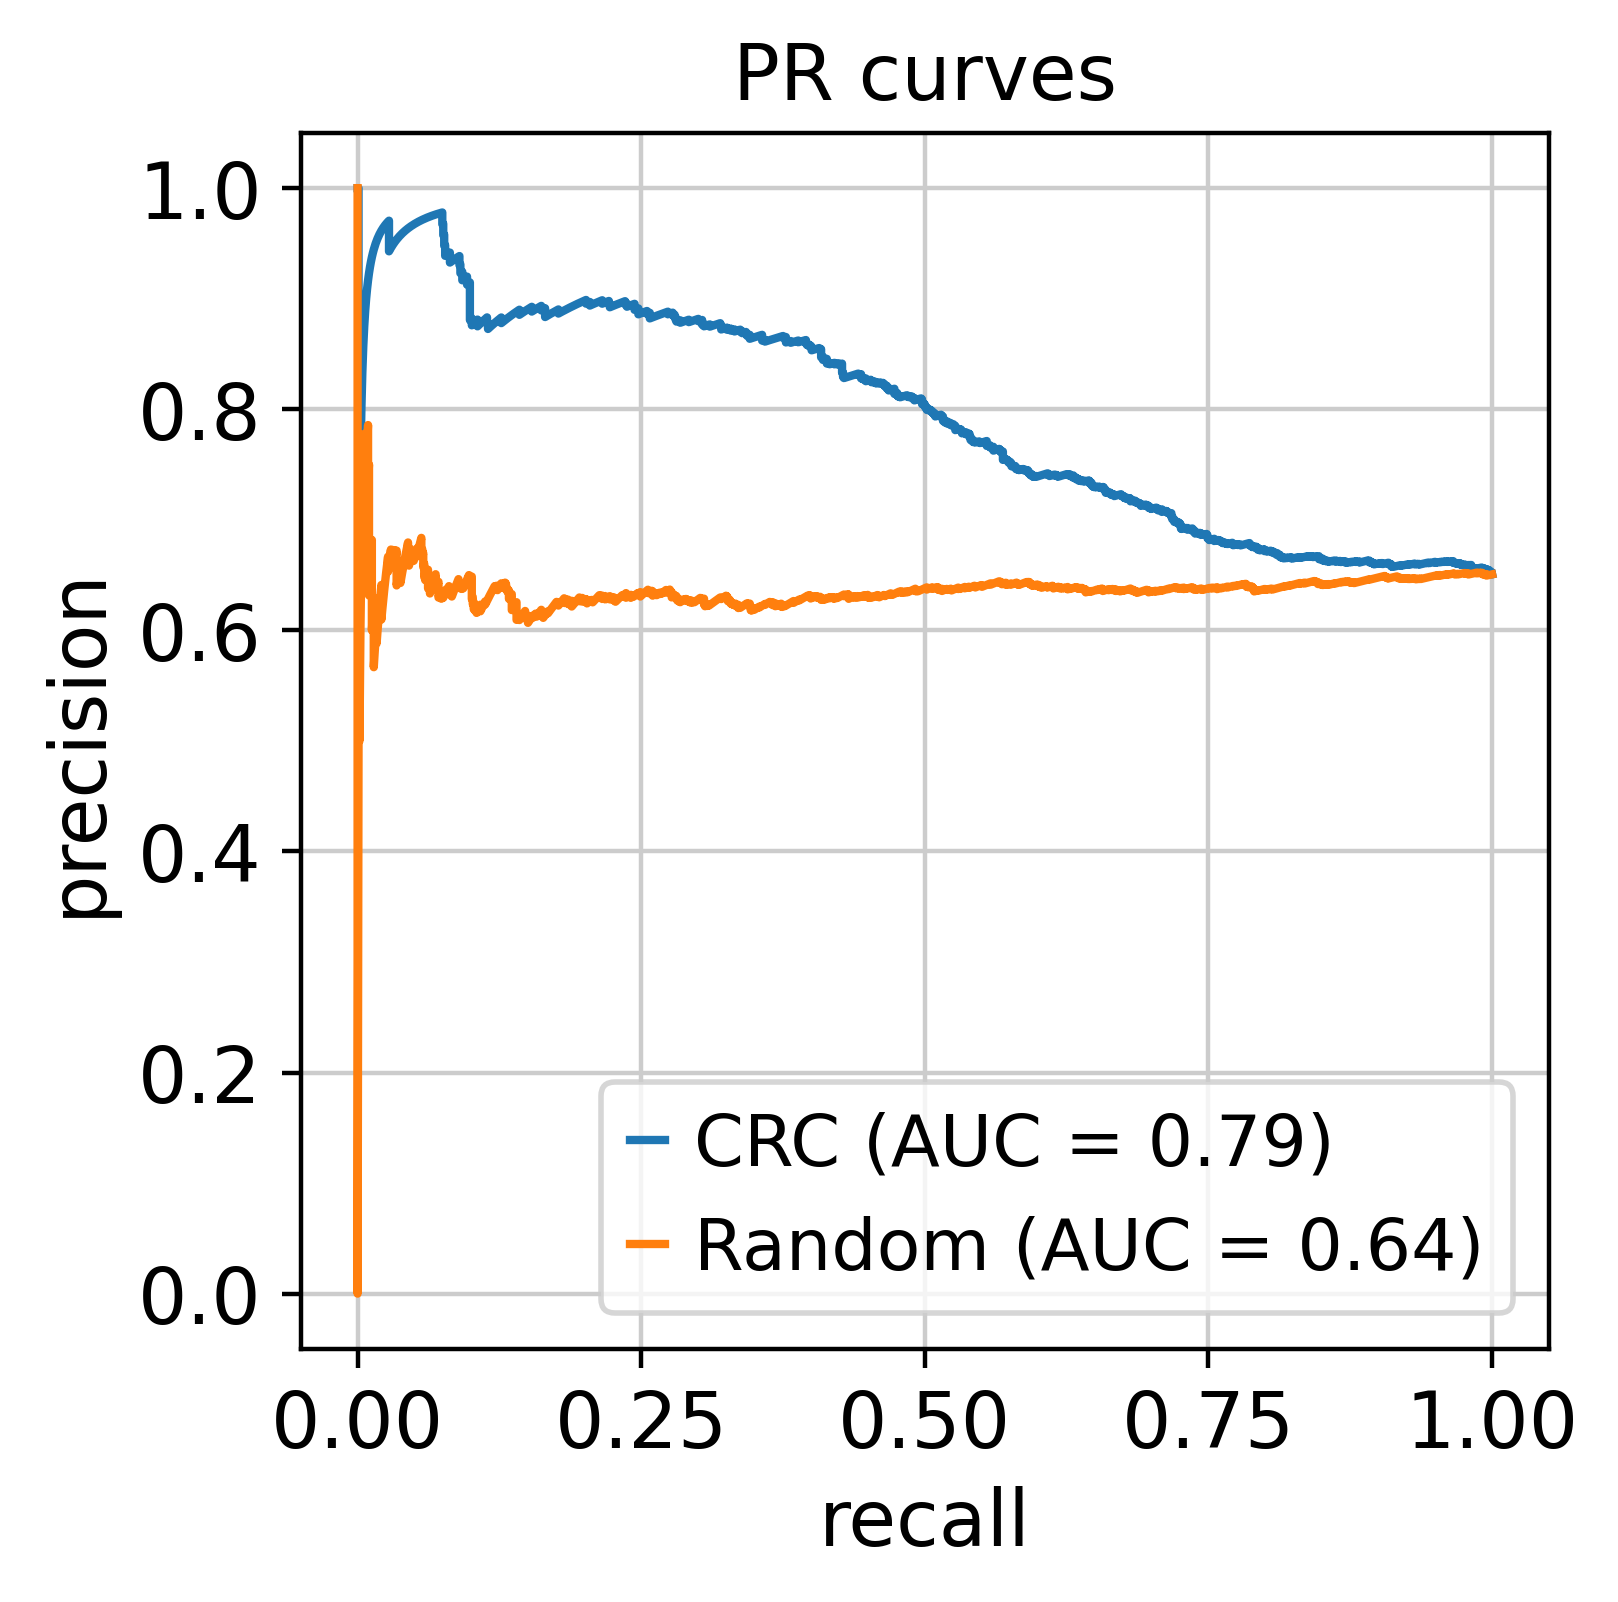

In [19]:
plt.plot(recall, precision, "-", 
         label=f"CRC (AUC = {round(auc(recall, precision),2)})")
plt.plot(recall2, precision2, "-", 
         label=f"Random (AUC = {round(auc(recall2, precision2),2)})")

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("PR curves")
plt.legend()

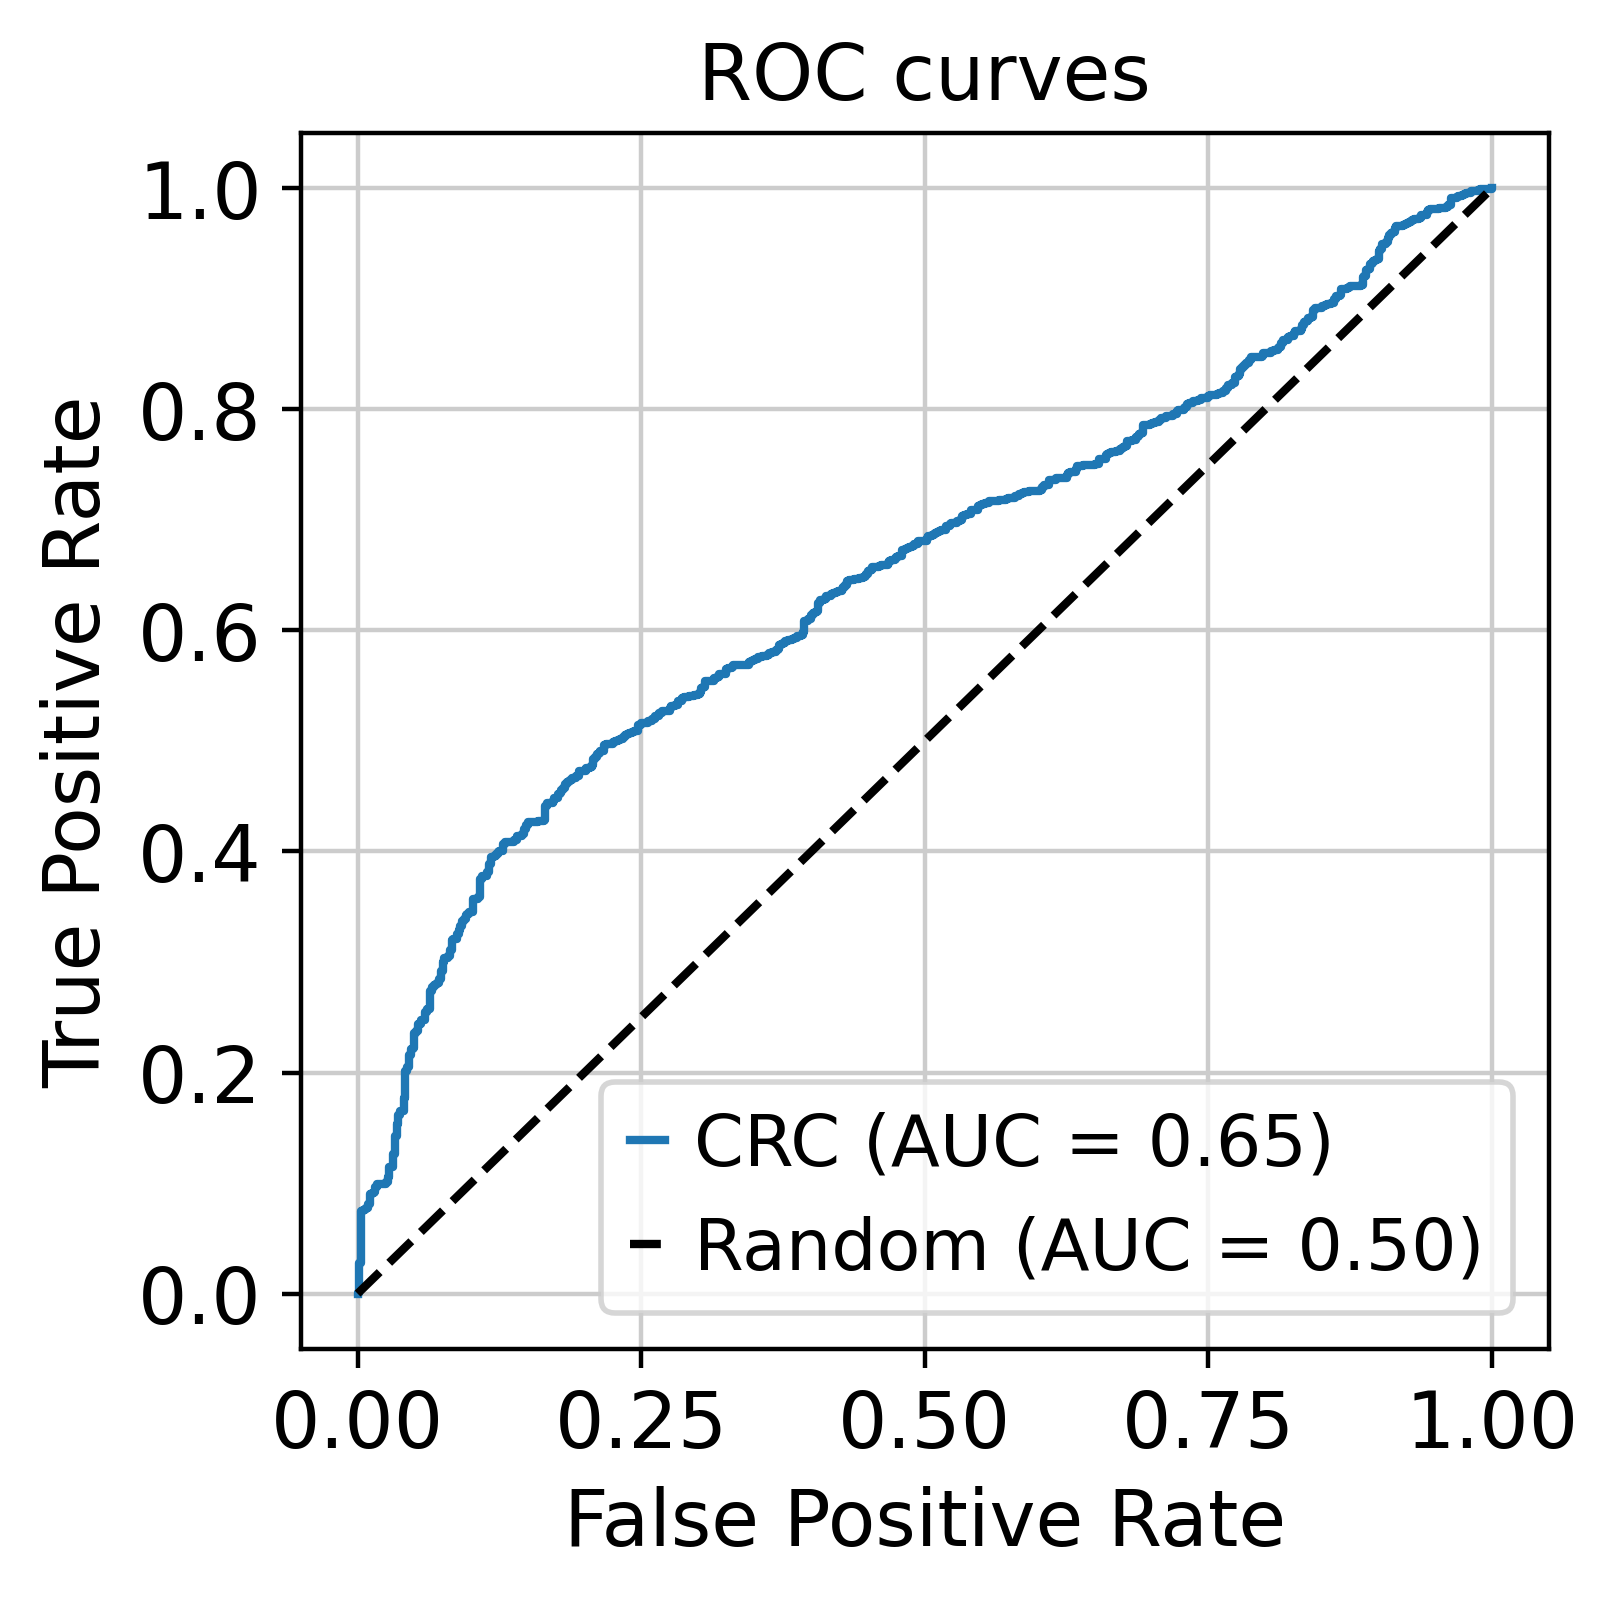

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(adata0.obs.condition, 
                                         adata0.obs.mean_dist, 
                                         pos_label='cancer')

plt.plot(fpr, tpr, "-", 
         label=f"CRC (AUC = {round(metrics.auc(fpr, tpr),2)})")

plt.plot([0, 1], [0, 1], "k--", 
         label="Random (AUC = 0.50)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()

In [21]:
raw_exp = pd.DataFrame(MinMaxScaler().fit_transform(adata_cancer.raw.X.toarray()), 
                       index=adata_cancer.obs_names, 
                       columns=adata_cancer.raw.var_names)

raw_exp['isnormal']=adata_cancer.obs.isnormal

In [22]:
adata_cancer.uns['log1p']["base"] = None

res = wilcoxauc(adata_cancer, group_name='isnormal')

Text(51.56944444444444, 0.5, 'AUC score in disease cells')

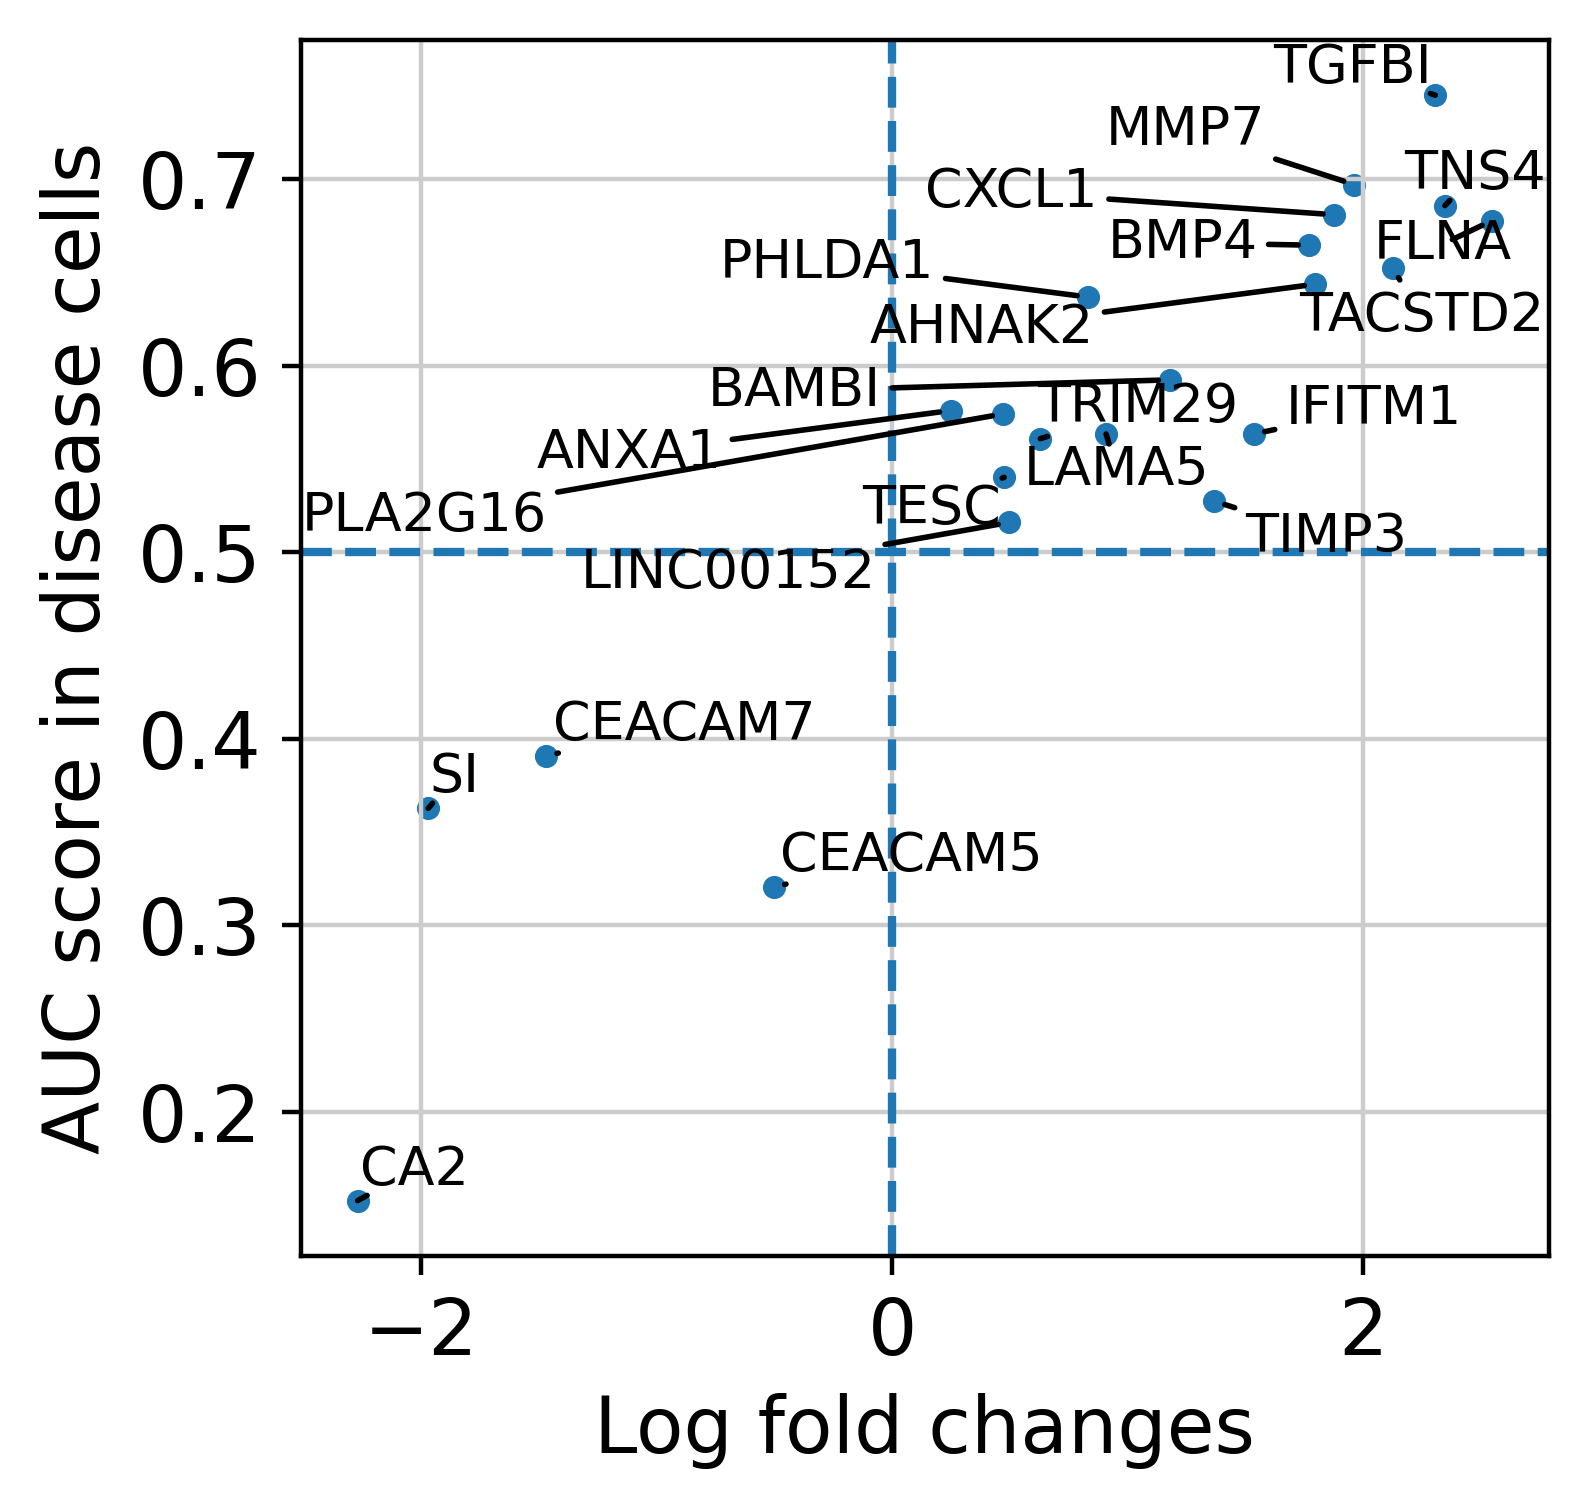

In [23]:
forplot = res[res.names.isin(["PLA2G16", "FLNA", "AHNAK2", "TRIM29", 
    "TIMP3", "IFITM1", "TNS4", "PHLDA1", "TACSTD2", "TESC", "CXCL1", 
    "LAMA5", "MMP7", "TGFBI", "ANXA1", "LINC00152", "BMP4", "BAMBI",
    'CEACAM5', 'CEACAM7','CA2', 'SI'])]

fig, ax = plt.subplots()
from adjustText import adjust_text

names=forplot[forplot.group=='abnormal']['names'].tolist()
xs=forplot[forplot.group=='abnormal']['logfoldchanges'].tolist()
ys=forplot[forplot.group=='abnormal']['auc'].tolist()

ax.scatter(x=xs,y=ys, s=10,label="Not significant")

texts = [ax.text(xs[i], ys[i], txt, fontsize='x-small') for i,txt in enumerate(names)]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'))

plt.axhline(y=0.5, linestyle='--')
plt.axvline(x=0, linestyle='--')

plt.xlabel("Log fold changes")
plt.ylabel("AUC score in disease cells")

### plot

<Axes: title={'center': 'normal'}, xlabel='UMAP1', ylabel='UMAP2'>

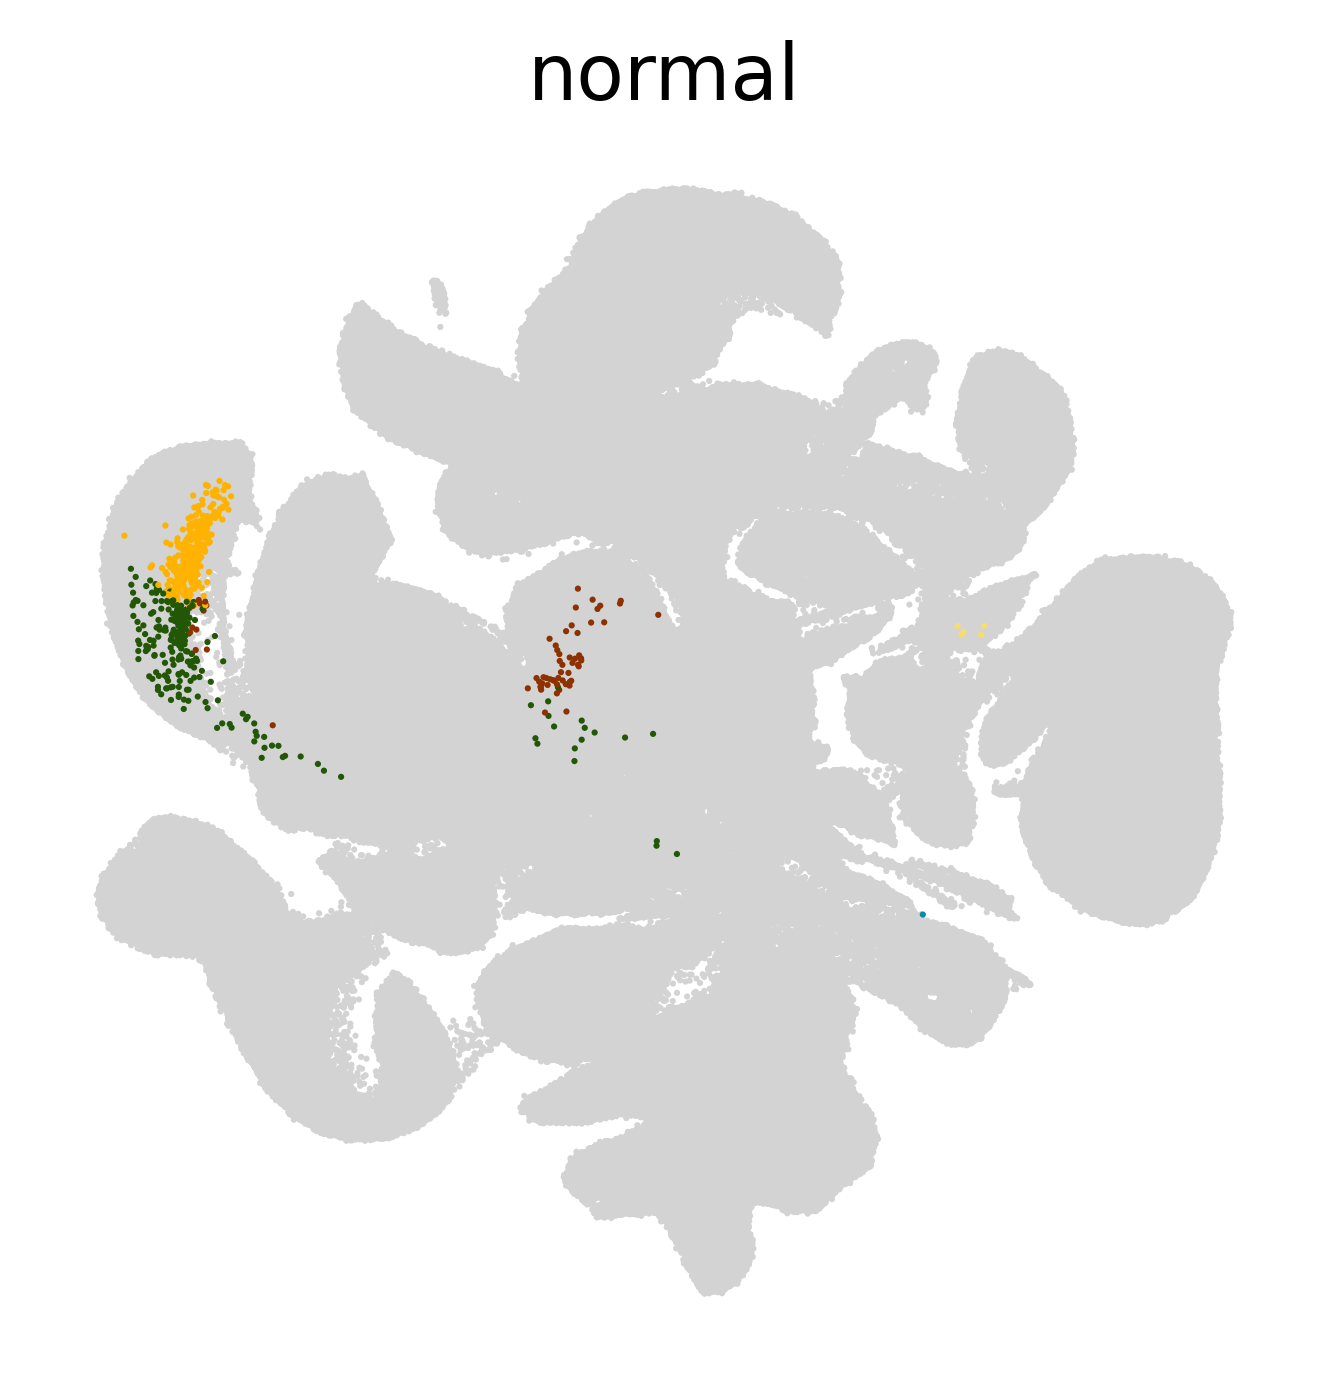

In [24]:
sc.pl.umap(anndata.AnnData.concatenate(*[adata_latent[(adata_latent.obs.condition=='normal')],  
                          adata_latent_source], join='outer', fill_value=0), 
       color='predict_level_2_late', show=False, palette=plate_level_all,
       frameon=False, size=5, legend_loc=None, title='normal')

<Axes: title={'center': 'cancer'}, xlabel='UMAP1', ylabel='UMAP2'>

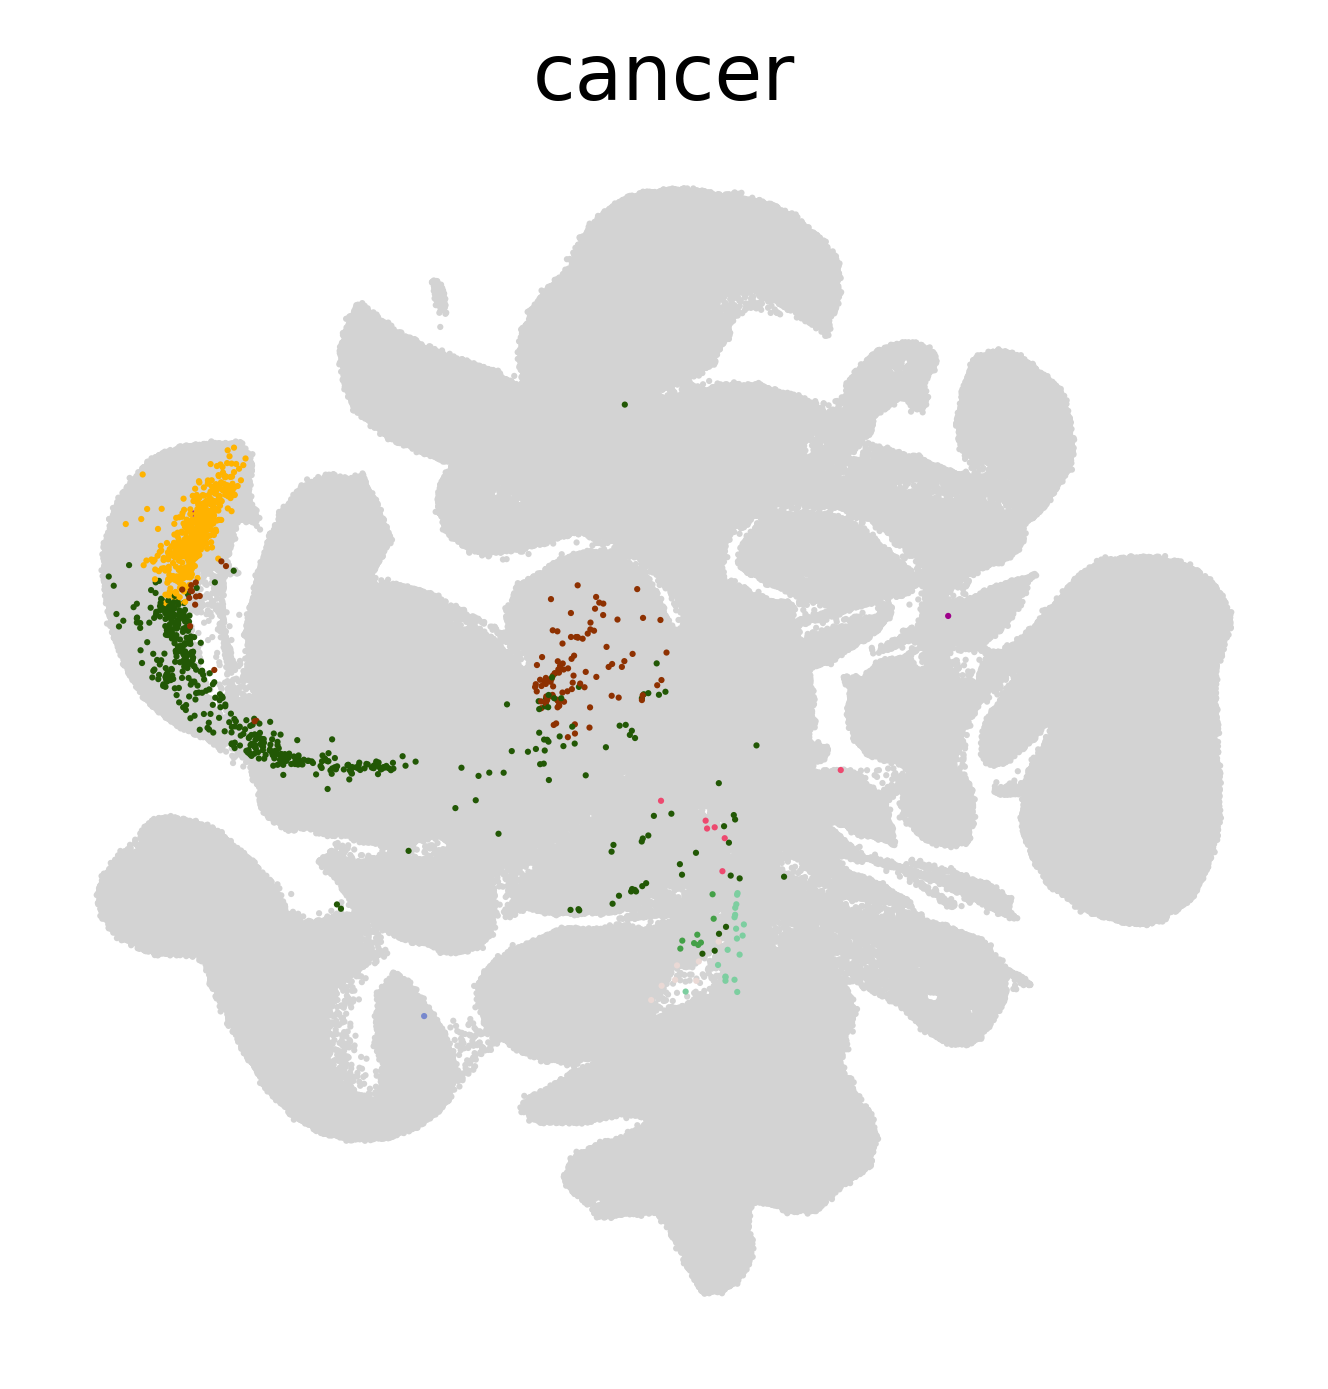

In [25]:
sc.pl.umap(anndata.AnnData.concatenate(*[adata_latent[(adata_latent.obs.condition=='cancer')], 
                              adata_latent_source], join='outer', fill_value=0),
           color='predict_level_2_late', show=False, palette=plate_level_all,
           frameon=False, size=5, legend_loc=None, title='cancer')

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

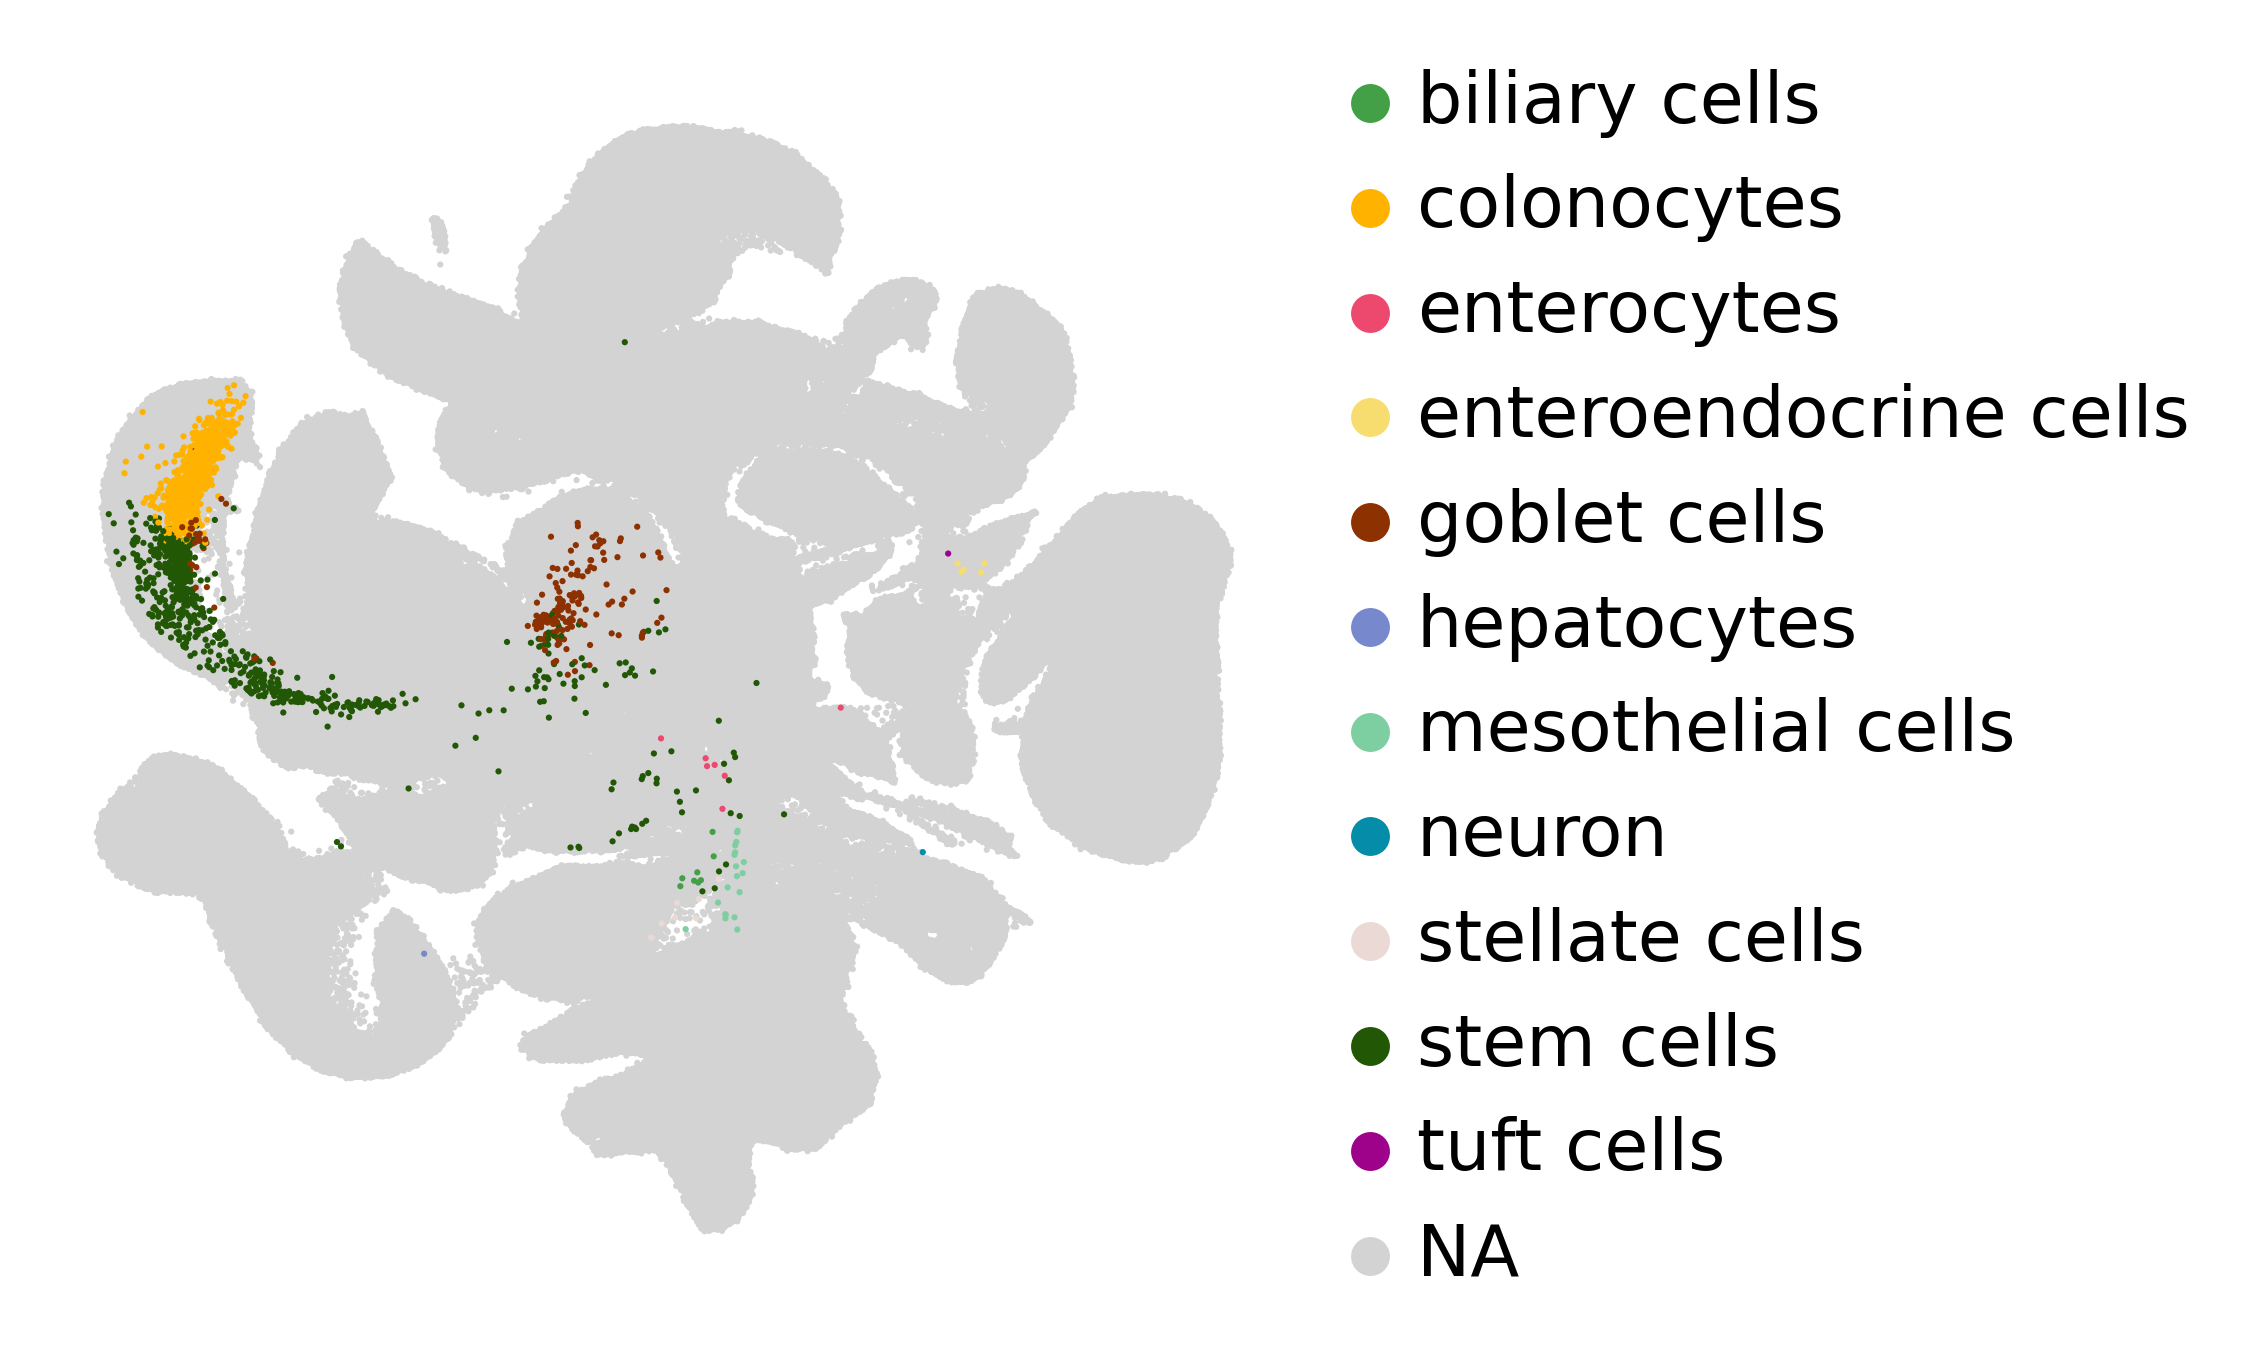

In [26]:
sc.pl.umap(anndata.AnnData.concatenate(*[adata_latent, 
                adata_latent_source], join='outer', fill_value=0),
           color='predict_level_2_late', show=False, 
           palette=plate_level_all,
           frameon=False, size=5, title='')

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

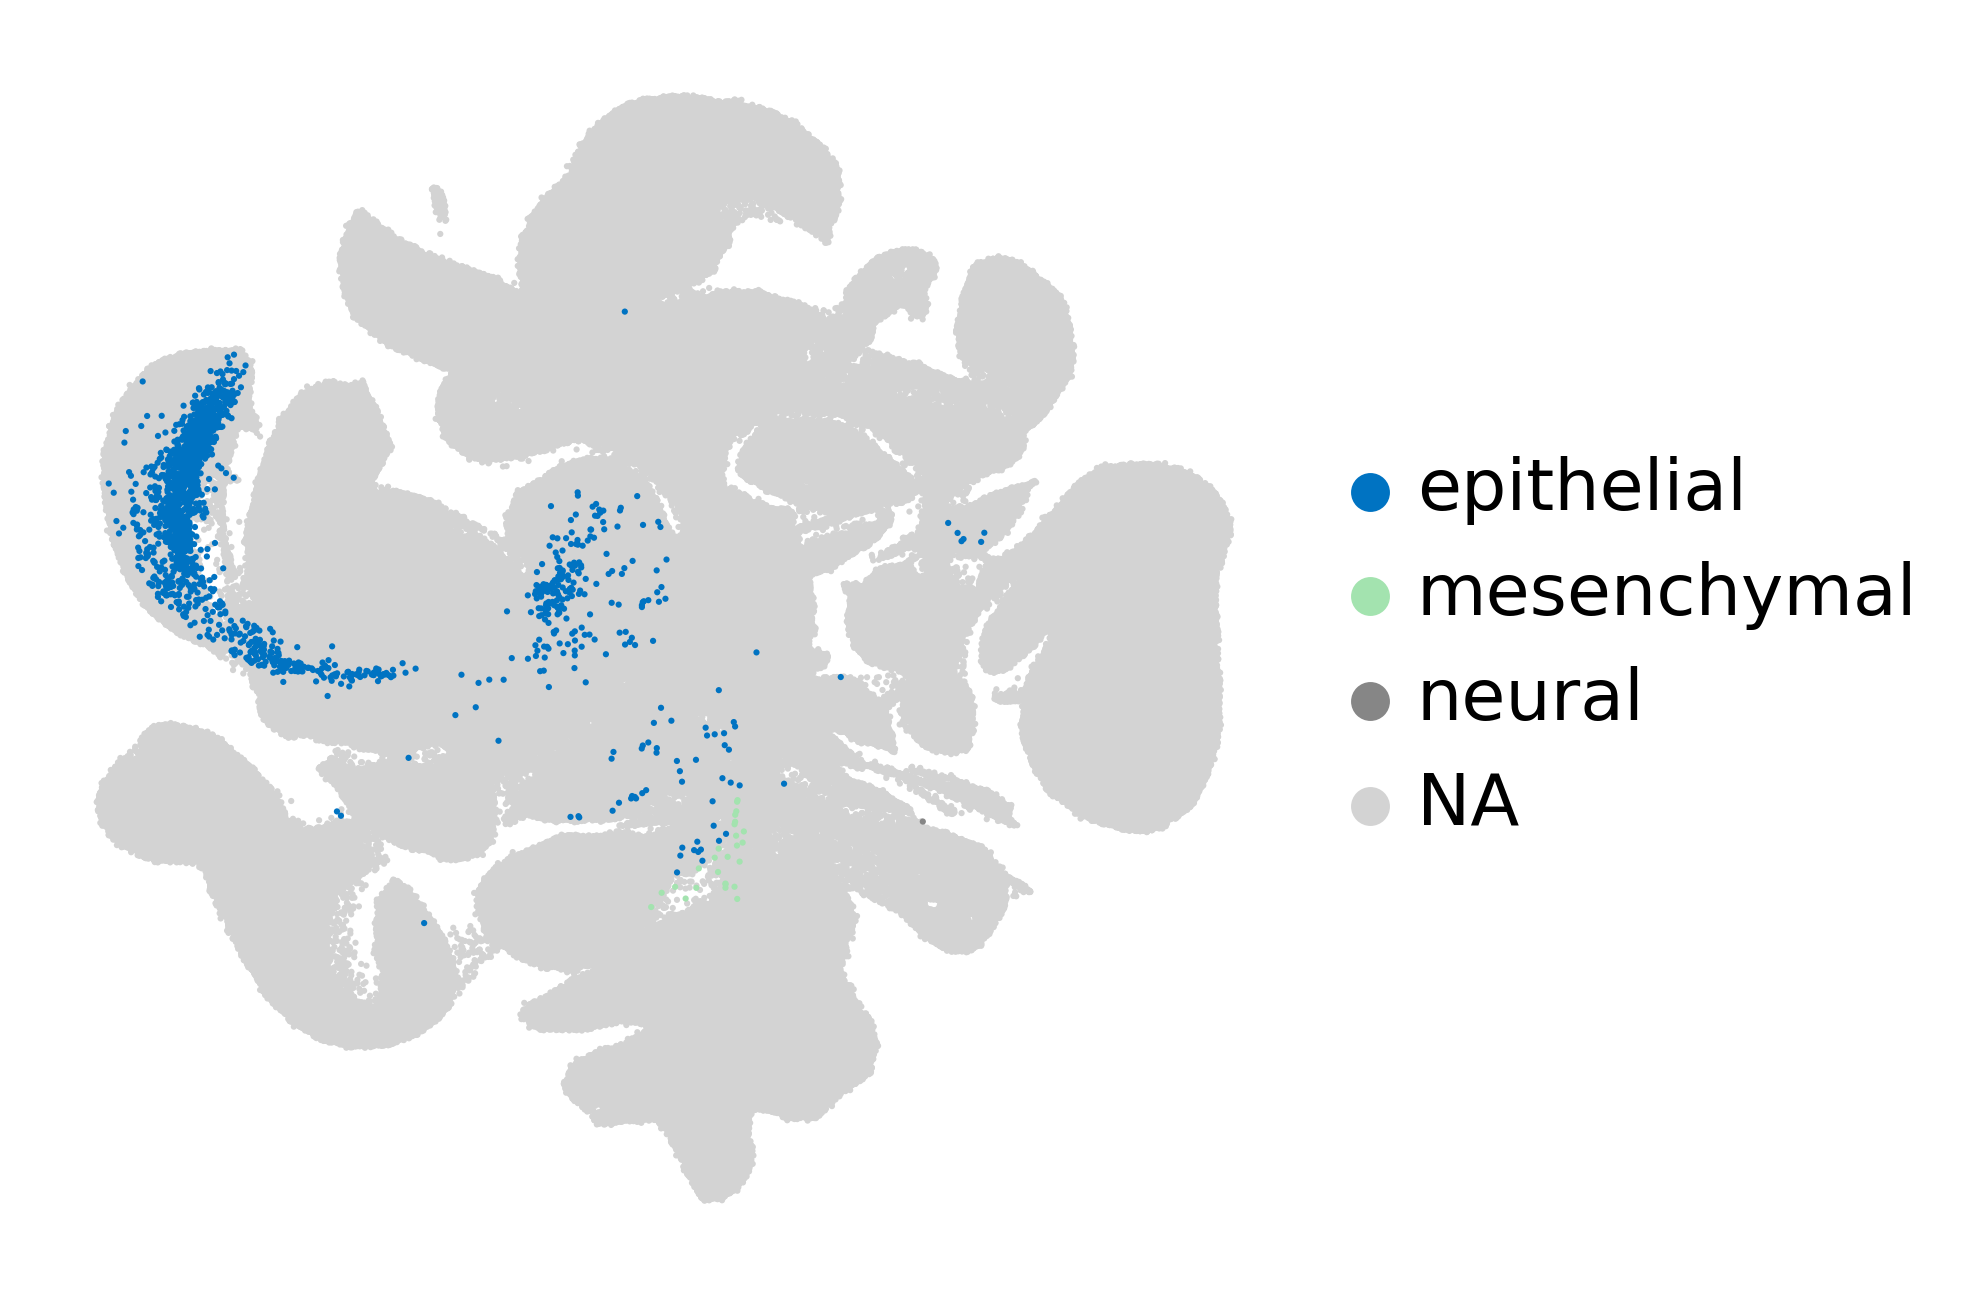

In [27]:
sc.pl.umap(anndata.AnnData.concatenate(*[adata_latent, 
                adata_latent_source], join='outer', fill_value=0),
           color='predict_level_1_late', show=False, 
           palette=plate_level_all,
           frameon=False, size=5, title='')

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

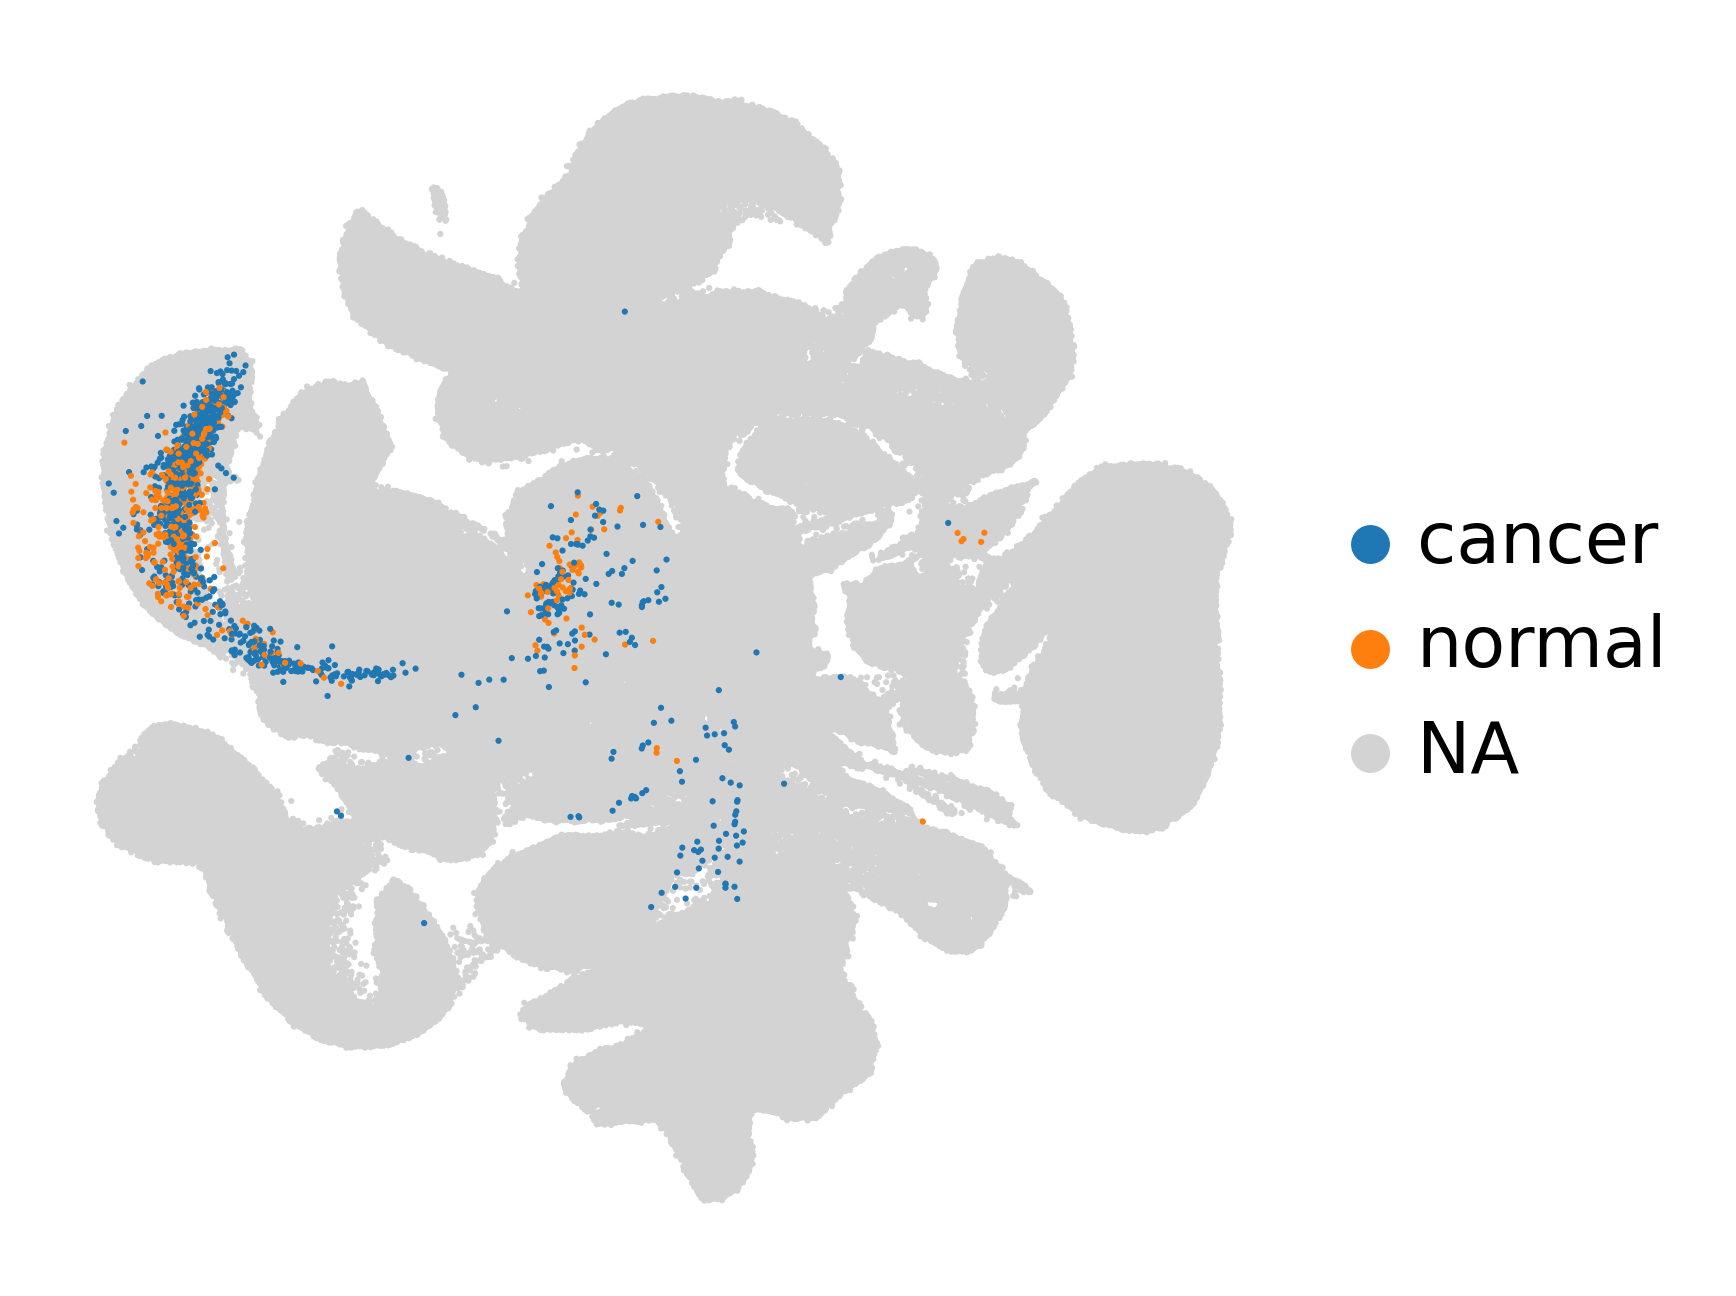

In [28]:
sc.pl.umap(anndata.AnnData.concatenate(*[adata_latent, 
                adata_latent_source], join='outer', fill_value=0),
           color='condition', show=False, 
           frameon=False, size=5, title='')

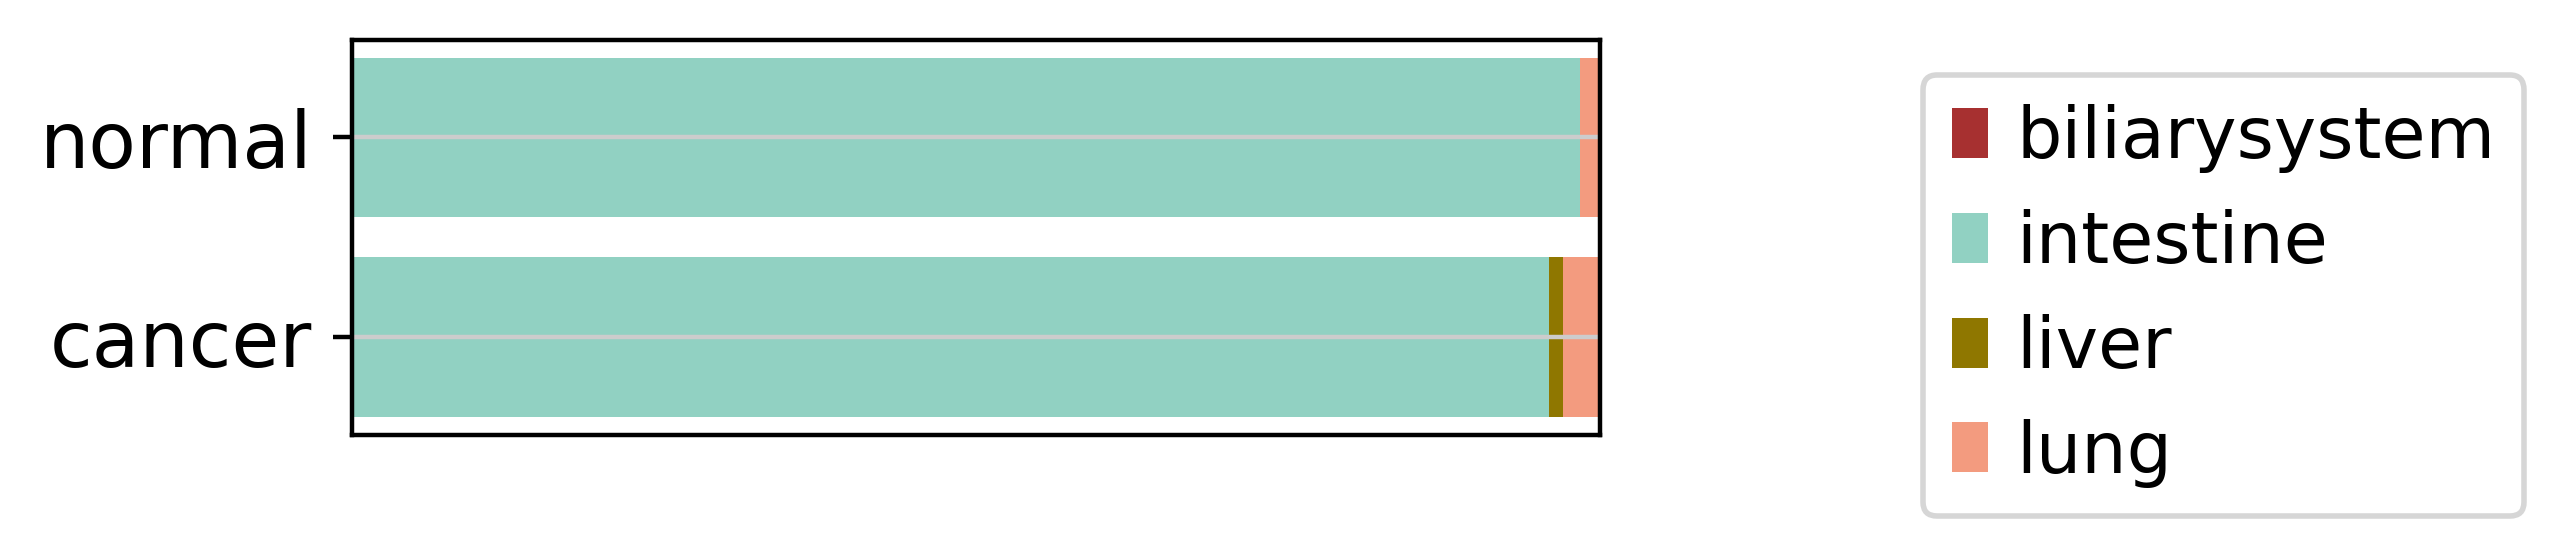

In [29]:
aaa = adata_latent.obs.groupby(['condition','predict_tissue']).count()['sample_id'].reset_index()
aaa = pd.merge(aaa, aaa.groupby('condition').sum().reset_index(), on='condition')
aaa['pect']=aaa['sample_id_x']/aaa['sample_id_y']
aaa=aaa.set_index('predict_tissue').pivot(columns='condition', values='pect')
aaa=aaa.fillna(0).T[::-1]

category_names = aaa.columns.tolist()
labels = aaa.index.tolist()
data = np.array(aaa)
data_cum = data.cumsum(axis=1)

fig, ax = plt.subplots(figsize=(4, 1.3))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, colname in enumerate(category_names):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.8,
            label=colname, color=plate_level_all[colname])
    xcenters = starts + widths / 2
    
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1))

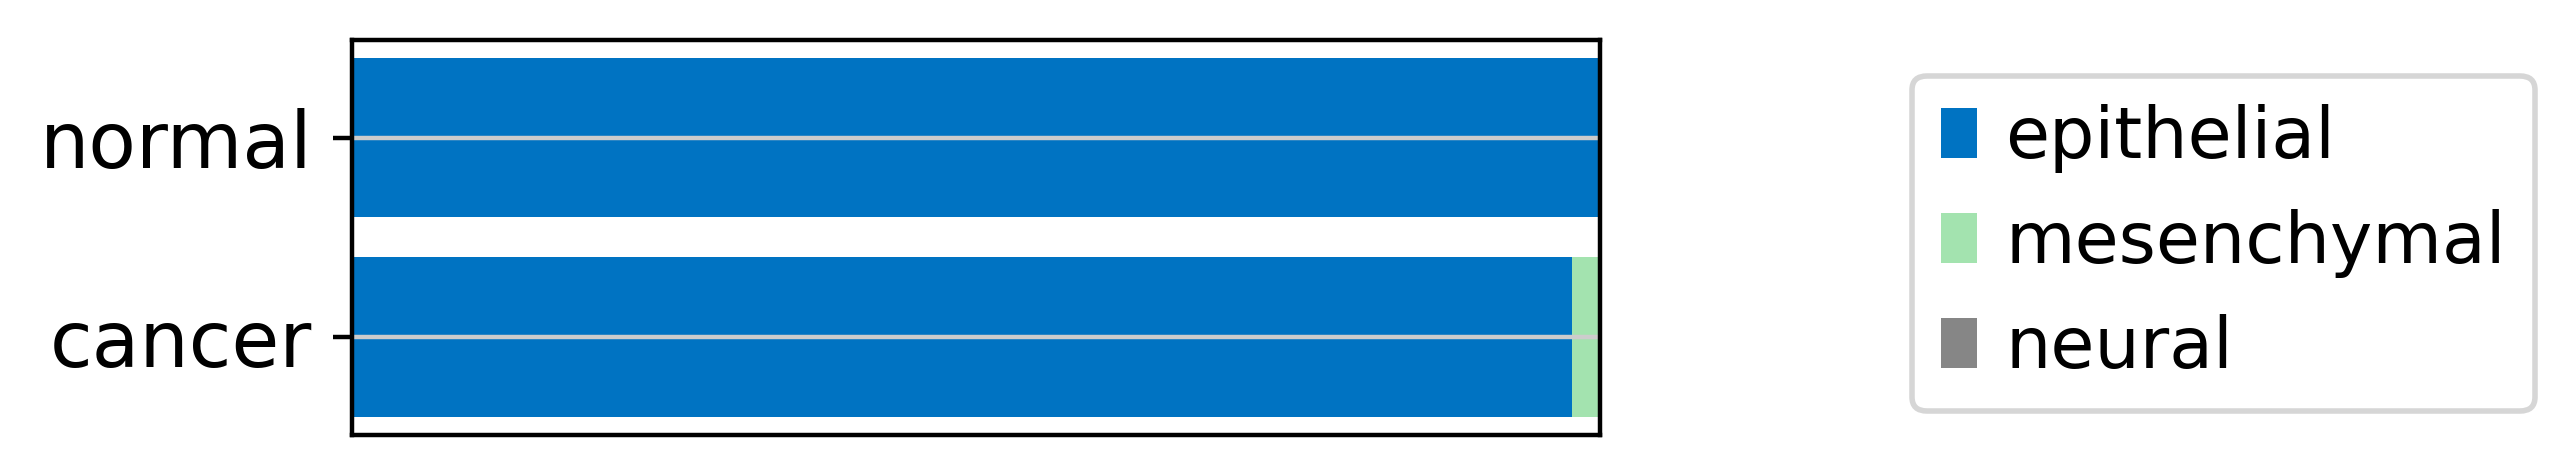

In [30]:
aaa = adata_latent.obs.groupby(['condition','predict_level_1_late']).count()['sample_id'].reset_index()
aaa = pd.merge(aaa, aaa.groupby('condition').sum().reset_index(), on='condition')
aaa['pect']=aaa['sample_id_x']/aaa['sample_id_y']
aaa=aaa.set_index('predict_level_1_late').pivot(columns='condition', values='pect')
aaa=aaa.fillna(0).T[::-1]

category_names = aaa.columns.tolist()
labels = aaa.index.tolist()
data = np.array(aaa)
data_cum = data.cumsum(axis=1)

fig, ax = plt.subplots(figsize=(4, 1.3))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, colname in enumerate(category_names):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.8,
            label=colname, color=plate_level_all[colname])
    xcenters = starts + widths / 2
    
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1))

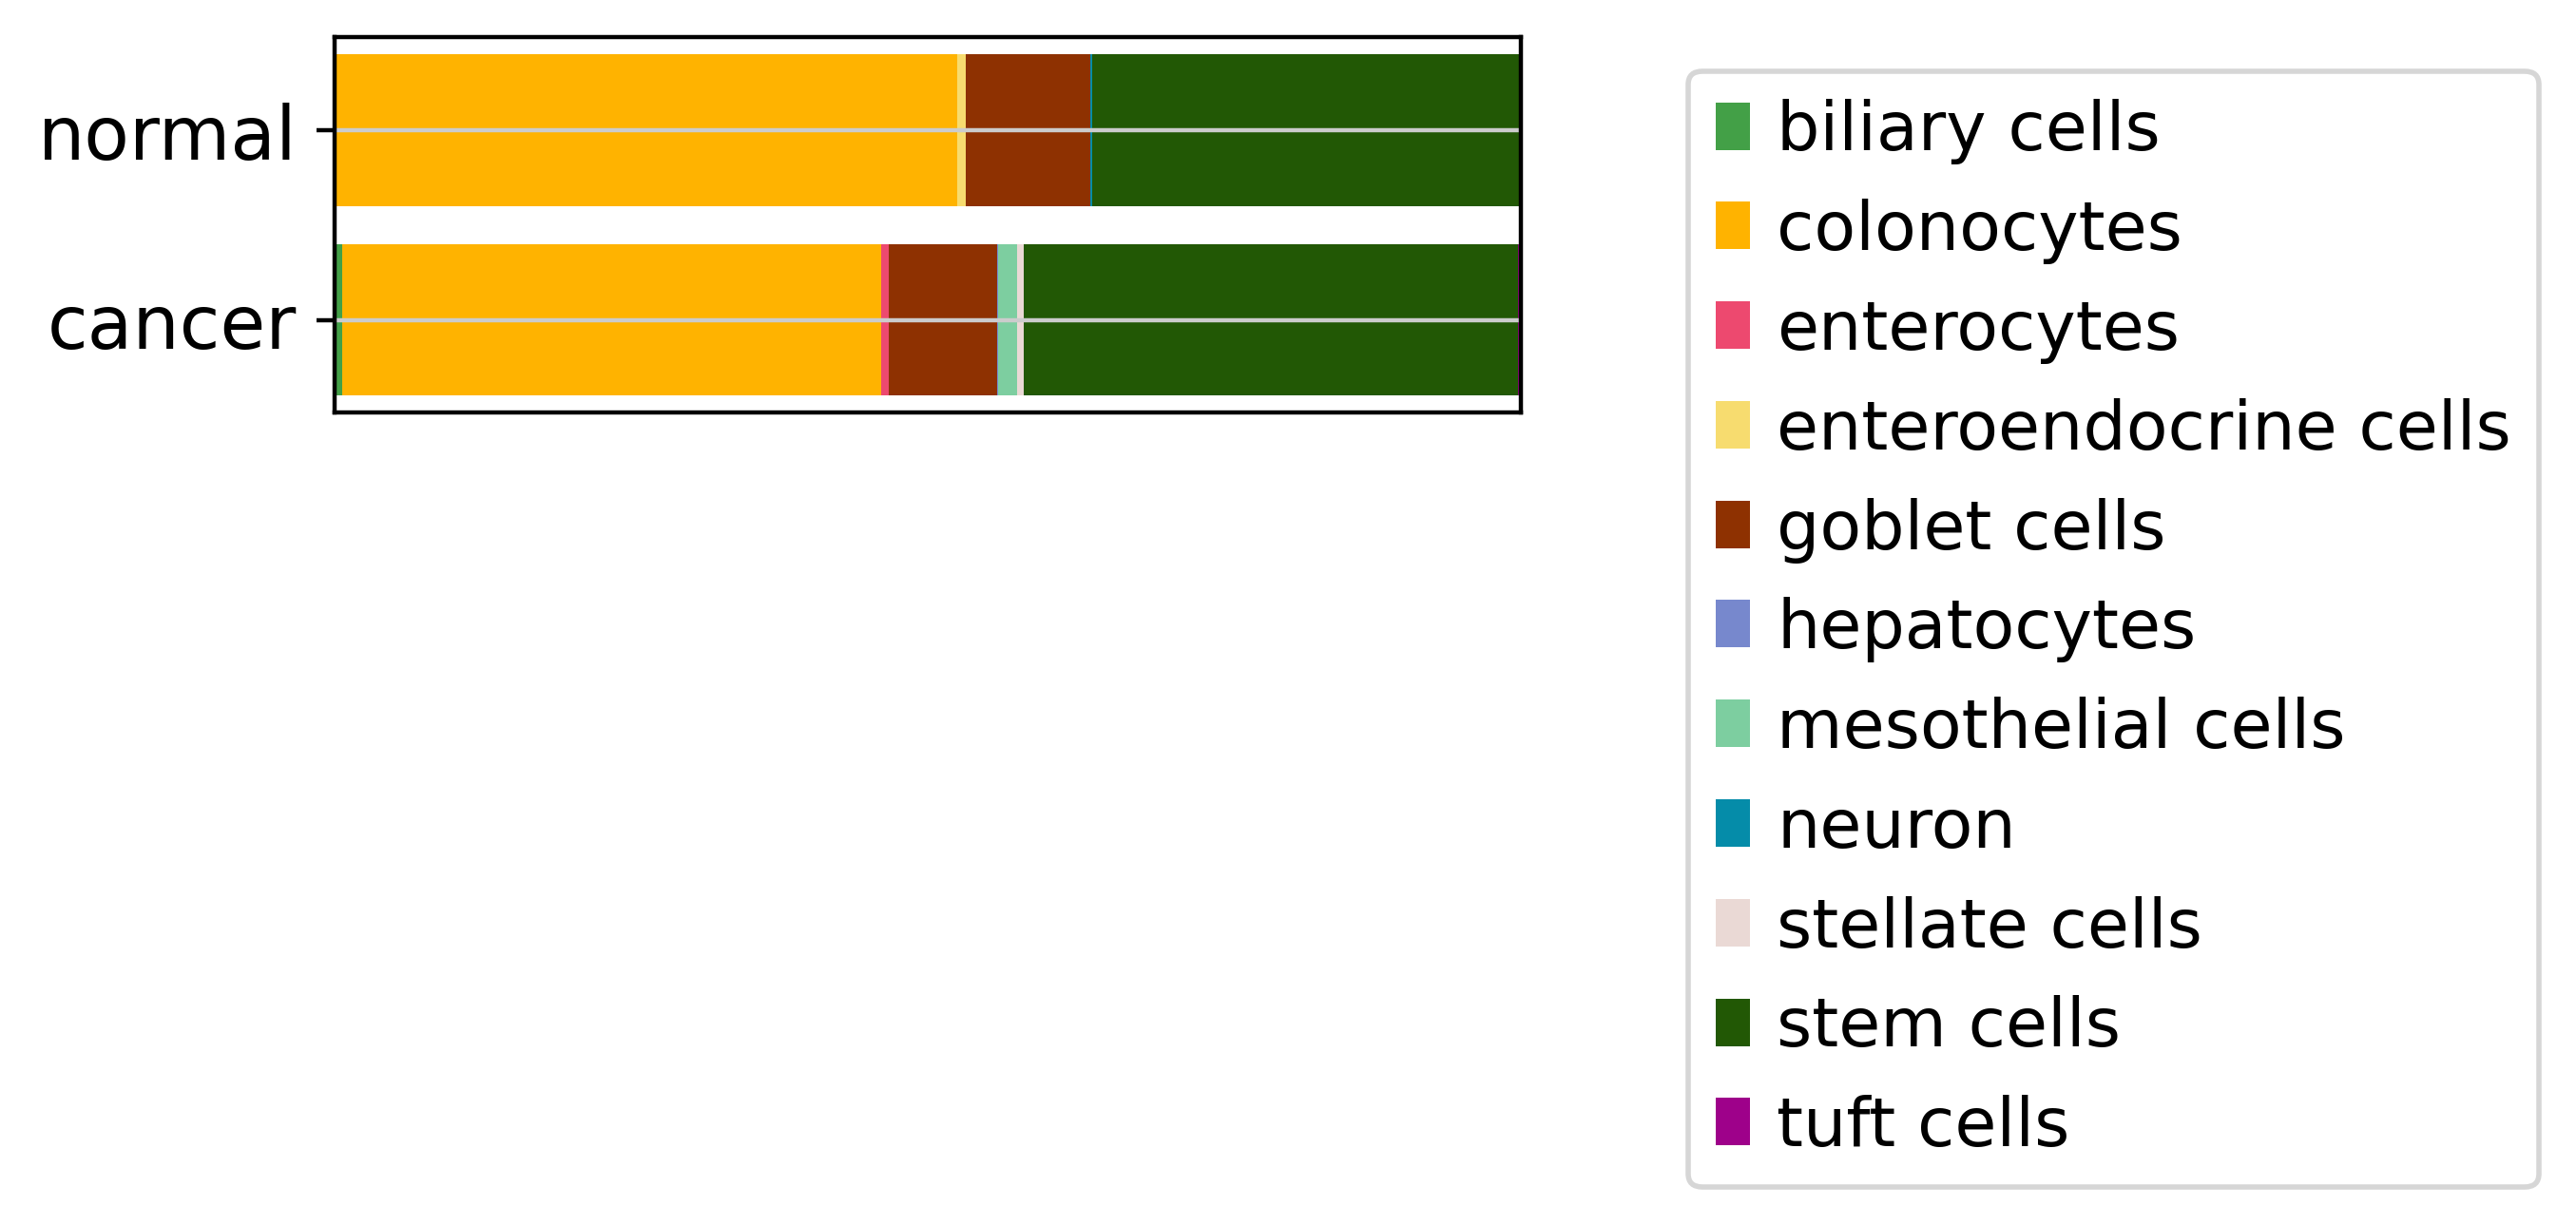

In [31]:
aaa = adata_latent.obs.groupby(['condition','predict_level_2_late']).count()['sample_id'].reset_index()
aaa = pd.merge(aaa, aaa.groupby('condition').sum().reset_index(), on='condition')
aaa['pect']=aaa['sample_id_x']/aaa['sample_id_y']
aaa=aaa.set_index('predict_level_2_late').pivot(columns='condition', values='pect')
aaa=aaa.fillna(0).T[::-1]

category_names = aaa.columns.tolist()
labels = aaa.index.tolist()
data = np.array(aaa)
data_cum = data.cumsum(axis=1)

fig, ax = plt.subplots(figsize=(4, 1.3))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, colname in enumerate(category_names):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.8,
            label=colname, color=plate_level_all[colname])
    xcenters = starts + widths / 2
    
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1))